## Demo_CM
This is a demo for visualizing the Confusion Matrix of a Neuron Network

To run this demo from scratch, you need first generate a BadNet attack result by using the following cell

In [ ]:
! python ../../attack/badnet.py --save_folder_name badnet_demo

or run the following command in your terminal

```python attack/badnet.py --save_folder_name badnet_demo```

### Step 1: Import modules and set arguments

In [1]:
import sys, os
import yaml
import torch
import numpy as np
import torchvision.transforms as transforms

sys.path.append("../")
sys.path.append("../../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.fix_random import fix_random
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.save_load_attack import load_attack_result
from utils.defense_utils.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from utils.defense_utils.dbd.model.model import SelfModel, LinearModel


In [2]:

### Basic setting: args
args = get_args(True)

########## For Demo Only ##########
args.yaml_path = "../../"+args.yaml_path
args.result_file_attack = "badnet_demo"
######## End For Demo Only ##########

with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../..//record/" + args.result_file_attack


### Step 2: Load data

In [3]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")

# Select all classes and all samples
selected_classes = np.arange(args.num_classes)

# keep the same transforms for train and test dataset for better visualization
result_attack["clean_train"].wrap_img_transform = result_attack["clean_test"].wrap_img_transform 
result_attack["bd_train"].wrap_img_transform = result_attack["bd_test"].wrap_img_transform 

args.visual_dataset = 'clean_train'
# Create dataset
if args.visual_dataset == 'clean_train':
    visual_dataset = result_attack["clean_train"]
elif args.visual_dataset == 'clean_test':
    visual_dataset = result_attack["clean_test"]
elif args.visual_dataset == 'bd_train':  
    visual_dataset = result_attack["bd_train"]
elif args.visual_dataset == 'bd_test':
    visual_dataset = result_attack["bd_test"]
else:
    assert False, "Illegal vis_class"

print(f'Create visualization dataset with \n \t Dataset: {args.visual_dataset} \n \t Number of samples: {len(visual_dataset)}  \n \t Selected classes: {selected_classes}')

# Create data loader
data_loader = torch.utils.data.DataLoader(
    visual_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

# Create denormalization function
for trans_t in data_loader.dataset.wrap_img_transform.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)



Files already downloaded and verified
Files already downloaded and verified
loading...
Create visualization dataset with 
 	 Dataset: clean_train 
 	 Number of samples: 50000  
 	 Selected classes: [0 1 2 3 4 5 6 7 8 9]


### Step 3: Load Model

In [4]:
# Load model
model_visual = generate_cls_model(args.model, args.num_classes)
model_visual.load_state_dict(result_attack["model"])
model_visual.to(args.device)
# !!! Important to set eval mode !!!
model_visual.eval()
print(f"Load model {args.model} from {args.result_file_attack}")

Load model preactresnet18 from badnet_demo


### Step 4: Plot Confusion Matrix

Plotting Confusion Matrix
Normalized confusion matrix
Test Acc: 95.230%(47615/50000)
Test Acc (Target only): 99.980%(4999/5000)


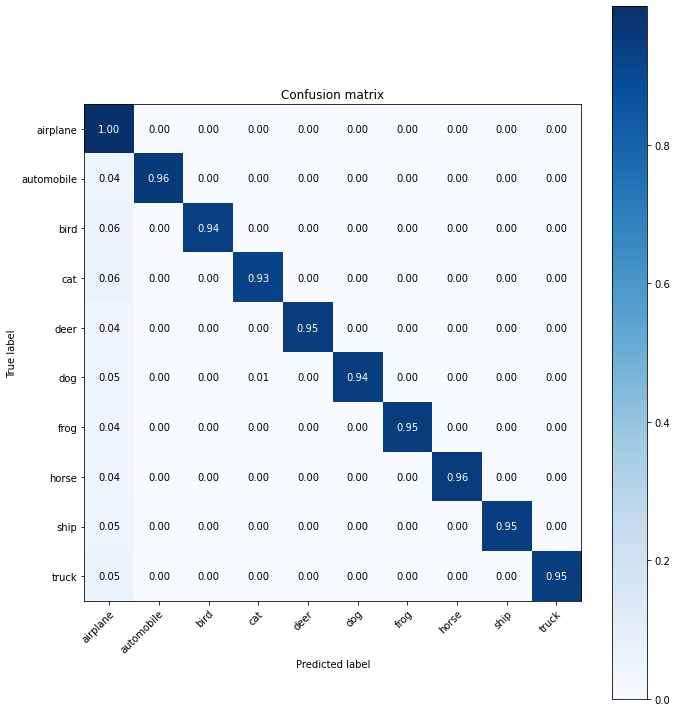

In [5]:
############## Confusion Matrix ##################
print("Plotting Confusion Matrix")

target_class = args.target_class
poison_class = args.num_classes
class_names = args.class_names

# Evaluation
criterion = torch.nn.CrossEntropyLoss()
total_clean_test, total_clean_correct_test, test_loss = 0, 0, 0
target_correct, target_total = 0, 0

true_labls = []
pred_labels = []
for i, (inputs, labels, *other_info) in enumerate(data_loader):
    inputs, labels = inputs.to(args.device), labels.to(args.device)
    outputs = model_visual(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    total_clean_correct_test += torch.sum(torch.argmax(outputs[:], dim=1) == labels[:])
    target_correct += torch.sum(
        (torch.argmax(outputs[:], dim=1) == target_class) * (labels[:] == target_class)
    )
    target_total += torch.sum(labels[:] == target_class)

    total_clean_test += inputs.shape[0]
    avg_acc_clean = float(total_clean_correct_test.item() * 100.0 / total_clean_test)
    prediction = torch.argmax(outputs[:], dim=1)
    true_labls.append(labels.detach().cpu().numpy())
    pred_labels.append(prediction.detach().cpu().numpy())
    
true_labls = np.concatenate(true_labls)
pred_labels = np.concatenate(pred_labels)

plot_confusion_matrix(
    true_labls,
    pred_labels,
    classes=class_names,
    normalize=True,
    title="Confusion matrix",
    save_fig_path=None,
)

print(
    "Test Acc: {:.3f}%({}/{})".format(
        avg_acc_clean, total_clean_correct_test, total_clean_test
    )
)
print(
    "Test Acc (Target only): {:.3f}%({}/{})".format(
        target_correct / target_total * 100.0, target_correct, target_total
    )
)
